In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
import os

The goal of this project is to process real-life experimental data and provide solvent suggestion based on selected descriptors

In [291]:
class SolvPredPlus:
    
    def __init__(self, all_cand_param_csv, op_folder = "test", **kwargs):
        self.load_cand_param(all_cand_param_csv, **kwargs)
        
        if os.path.isdir(op_folder):
            pass
        else:
            os.mkdir(op_folder)
        self.op_folder_path = os.getcwd() + ".\\" + op_folder
        
    
    def load_cand_param(self, all_cand_param_csv, **kwargs):
        """
        load database for all solvent parameters for candidates
        all_cand_param_csv: string, file name.
        The column row in the example includes: solvent, D, P, H, epsilon, pi_star, HBD, HBA, logP_solv
        user can specify additional properties to be calculated while loading candidate database. 
        for example, hansen distance with starting material and the product
        kwargs:
        do_hansen_dist: bool
        hansen_dist_with: list of dict or one dict, keys are comp_name, D, P, H
        """
        all_solv_cand_df = pd.read_csv(all_cand_param_csv)
        #convert to dictionary
        self.all_cand_param_dict = all_solv_cand_df.to_dict(orient='records')
        print(f"Loading candidate parameters: success.\n")
        
    def _calc_hansen_dist(self, crt_df, hansen_dist_with_dict):
        """
        calculate hansen distance with current dataframe HSP columns
        hansen_dist_with_dict: dictionary
        """
        hansen_dist_with_name = hansen_dist_with_dict["comp_name"]
        hansen_dist_col_name = '_'.join(['r', hansen_dist_with_name])
        this_D = hansen_dist_with_dict["D"]
        this_P = hansen_dist_with_dict["P"]
        this_H = hansen_dist_with_dict["H"]
        
        this_r = np.sqrt(4*(crt_df["D"]-this_D)**2 + (crt_df["P"] - this_P)**2 + (crt_df["H"] - this_H)**2)
        
        crt_df[hansen_dist_col_name] = this_r
        
        print(f"Calculate hansen distance with {hansen_dist_with_name}: success.")
        return crt_df

    
    def load_exp_data(self, ip_exp_csv, **kwargs):
        """
        ip_exp_csv is the file name of input experimental data.
        The columns of the data file should follow the naming rule as rxn_id, solv_1, precent_1, solv_2, percent_2, Y
        There could be more co-solvents column; the name should follow solv_#, precent_# structure.
        Y is the observable column, in the example is the yield.
        Important rule: the name for solvent must match the name used in the all_cand_param data file.
        Mixtures parameters will be calculated and attached in each entry.
        """
        full_exp_df = pd.read_csv(ip_exp_csv)
        self.all_co_solv_col_name = self._get_co_solv_col_name(full_exp_df)
        full_exp_dict = full_exp_df.to_dict(orient="records")
        
        #operate each row/entry one by one
        #fetch parameters of corresponding solvent from database
        #then scale by percentage
        all_comb_exp = []
        
        for exp in full_exp_dict:
            
            rxn_id = exp["rxn_id"]
            print(f"Process {rxn_id} starts..")
            
            for i, solv_col in enumerate(self.all_co_solv_col_name["solv_col"]):
                this_solv_name = exp[solv_col]
                
                if type(this_solv_name) is str:
                
                    percent_col = self.all_co_solv_col_name["percent_col"][i]
                    this_solv_percent = exp[percent_col]

                    #fetch all parameters for this solvent
                    this_solv_params = self._fetch_solv_param(this_solv_name)["full_params"]
                    #apply this_solv_percent to all parameters
                    this_solv_scaled_params = self._scale_param_by_percent(this_solv_params, this_solv_percent)

                    if i == 0:
                        mix_solv_params = this_solv_scaled_params
                    else:
                        mix_solv_params = self._add_dict(this_solv_scaled_params, mix_solv_params)
            
            #process kwargs if any
            #calculate hansen distance
            if "do_hansen_dist" in kwargs:

                if kwargs["do_hansen_dist"]:

                    if type(kwargs["hansen_dist_with"]) is dict:
                        #calculate the hansen distance to the all_solv_cand_df
                        #this is the case when only one species need to be calculated
                        all_solv_cand_df = self._calc_hansen_dist(all_solv_cand_df, kwargs["hansen_dist_with"])
                        pass
                    elif type(kwargs["hansen_dist_with"]) is list:
                        #loop over the list and append calculated hansen distance to the all_solv_cand_df
                        #this is the case when multiple species need to be calculated
                        for with_this_comp in kwargs["hansen_dist_with"]:
                            all_solv_cand_df = self._calc_hansen_dist(mix_solv_params, with_this_comp)
            
            #include mix_solv_params to the experimental dataset
            comb_exp_dict = exp
            comb_exp_dict.update(mix_solv_params)
            
            all_comb_exp.append(comb_exp_dict)
        
        self.all_comb_exp = all_comb_exp
        print("\nLoading data: success.\n")
        
        #the meta data can be saved or not, user's choice
        if "save_meta_data" in kwargs:
            if kwargs["save_meta_data"]:
                meta_data_file_name = "op_exp_data_with_full_params.csv"
                meta_data_df = pd.DataFrame(self.all_comb_exp)
                self._save_meta_data(meta_data_df, meta_data_file_name, keep_index = False)
            
                
#         return self.all_comb_exp
    
    def _save_meta_data(self, meta_data_df, meta_data_file_name, keep_index = True):
        to_csv_path = self.op_folder_path + "\\" + meta_data_file_name
        meta_data_df.to_csv(to_csv_path, index = keep_index)
        print(f"{meta_data_file_name} saved.")
        
    
    
    def rm_zero(self):
        """
        remove zero yield data from column Y
        """
        non_zero_comb = []
        
        for entry in self.all_comb_exp:
            if entry['Y'] == 0:
                pass
            elif type(entry['Y']) not in [float, int]:
                err_rxn_id = entry["rxn_id"]
                raise ValueError(f"Wrong format found in the observable column. Please check entry: {err_rxn_id}. \n")
            else:
                non_zero_comb.append(entry)
        
        self.non_zero_comb = non_zero_comb
        print("Remove invalid/zero data: success.\n")
        self.non_zero_comb_df = pd.DataFrame(self.non_zero_comb)
        
        return self.non_zero_comb
                
        
    #parse column name and extract solv, precent part from the full columns
        
    def _get_co_solv_col_name(self, full_exp_df):
        """
        look at how many co-solvents are used in experiment.
        return column names for the solv/percent block
        """
        all_col = full_exp_df.columns
        #confirm how many co-solvents to parse
        all_co_solv = {
            "solv_col":[],
            "percent_col":[]
        }

        for i, col in enumerate(all_col):
            if "solv" in col.lower():
                this_solv_col = col
                this_percent_col = all_col[i+1]
                all_co_solv["solv_col"].append(this_solv_col)
                all_co_solv["percent_col"].append(this_percent_col)

        if len(all_co_solv["solv_col"]) == 0 or len(all_co_solv["percent_col"]) == 0:
            raise ValueError("Co-solvent or percent column was missing. Please check the input experimental data file.\n")
        elif len(all_co_solv["solv_col"]) != len(all_co_solv["percent_col"]):
            raise ValueError("Potential offset was detected in co-solvent and percentage info. Please check the input experimental data file.\n")
        
        #get total number of solvents in the mixture
        self.total_num_of_solv = len(all_co_solv["solv_col"])
        
        return all_co_solv

            
    
    def _scale_param_by_percent(self, full_param_dict, this_solv_percent):
        """
        scale each parameter by the percentage of current solvent
        """
        scaled_num_params = {}
        for item in full_param_dict.keys():
            this_value = full_param_dict[item]
            if type(this_value) is not str:
                scaled_num_params[item] = this_solv_percent * this_value
        return scaled_num_params
    
    def _add_dict(self, dict_1, dict_2):
        """
        dict_1 and dict_2 have same structure
        """
        mix_dict = {}
        for item in dict_1.keys():
            mix_dict[item] = dict_1[item] + dict_2[item]
        return mix_dict
        
    
    def _fetch_solv_param(self, solv_name):
        """
        fetch solvent parameters by solv_name
        """
        
        this_solv_params = {}
#         print(solv_name)
        
        for entry in self.all_cand_param_dict:
            #print(entry)
            
            if solv_name.lower() == entry["solvent"].lower():
                this_solv_params["this_solvent"] = solv_name
                this_solv_params["full_params"] = entry
        
#         print(this_solv_params)
        if not this_solv_params["this_solvent"]:
            raise ValueError("Target solvent absent from candidate database. Please check the solvent name or the database entry.")
        
        return this_solv_params
    
    
    #do corr plot, default Y with descriptors, can be modified by do any two columns
    def plot_corr(self, observable = "Y", plot_all = True, x_to_plot = ["D", "P", "H"], save_plot = True, do_std = False, **kwargs):
        """
        plot correlation between observable and a series of x
        if plot_all is true, default will plot every descriptor in the dataset,
        otherwise, only descriptors in x_to_plot will be plot.
        plot details can be specified in kwargs
        """
        #standardise the whole dataframe
        self.all_std_df = self._get_zsocre_for_full_df(self.non_zero_comb_df)# to be done in get_zscore function
        
        
        #if corr plot needs to be done with std data
        if do_std:
            full_data = self.all_std_df
        #or corr plot will be done by original data
        else:
            full_data = self.non_zero_comb_df
        
        if plot_all:
            #get all descriptors from full data list, find it after Y
            dscpt_col = self._get_full_descriptors_col()
            x_to_plot = dscpt_col
       
        for x_name in x_to_plot:
            sns.relplot(data = full_data, x = full_data[x_name], y = full_data[observable])
            plt.xlabel(x_name, fontsize = 15)
            plt.ylabel(observable, fontsize = 15)
            plt.tick_params(axis='both', which='major', labelsize=15)
            plt.tight_layout()
            
            #save all corr plots to the op_folder
            if save_plot:
                fig_to_save_name = self.op_folder_path + "\\corr_plot_" + x_name
                plt.savefig(fig_to_save_name)
        
        
        
        #do heatmap of descriptors
        dscpt_col = x_to_plot
        dscpt_col_df = full_data[dscpt_col]
        self.dscpt_df_corr = dscpt_col_df.corr()
        
        plt.clf()
        sns.heatmap(self.dscpt_df_corr, cmap = "coolwarm")
        
        if save_plot:
            heat_map_to_save_name = self.op_folder_path + "\\descriptor_heat_map"
            plt.tight_layout()
            plt.savefig(heat_map_to_save_name)

            print("All correlation plots have been saved.\n")
        
        #plot heatmap with observable included
        obs_with_dscpt = x_to_plot
#         print(observable)
#         print(obs_with_dscpt)
        obs_with_dscpt.append(observable)
#         print(obs_with_dscpt)

        obs_with_dscpt_df = full_data[obs_with_dscpt]
        obs_with_dscpt_df_corr = obs_with_dscpt_df.corr()
        
        plt.clf()
        sns.heatmap(obs_with_dscpt_df_corr, cmap = "coolwarm", square = True)
        
        
        if save_plot:
            plot_to_save_name = self.op_folder_path + "\\obs_with_descriptor_heat_map"
            plt.tight_layout()
            plt.savefig(plot_to_save_name)
            print("Correlation plot including observable has been saved. \n")
            plt.show()
            
        
        #save meta data
        if "save_meta_data" in kwargs:
            if kwargs["save_meta_data"]:
                #save corr matrix of descriptors
                self._save_meta_data(self.dscpt_df_corr, "corr_mat_of_descriptors_only.csv", keep_index = True)
                #save corr matrix of descriptors and observable
                self._save_meta_data(obs_with_dscpt_df_corr, "corr_mat_of_descriptors_with_observable.csv", keep_index = True)
        
        #pass the correlation matrix involving observable to the global scope
        self.obs_with_dscpt_df_corr = obs_with_dscpt_df_corr
        
        pass
    
    def _get_full_descriptors_col(self):
        """
        get column name of all descriptors, assumed to be after Y
        """
        all_col_name = self.non_zero_comb_df.columns
        dscpt_start_idx = 0
        for i, col_name in enumerate(all_col_name):
            if col_name == "Y":
                dscpt_start_idx = i+1
        
        dscpt_col = list(all_col_name[dscpt_start_idx:])
        #print(dscpt_col)
        if len(dscpt_col) != 0:
            print(f"Generate full descriptor: success.")
        
        self.num_of_dscpt = len(dscpt_col) #number of descriptors determine how many PC will be generated by default
        print(f"{self.num_of_dscpt} numerical descriptors are found. \n")
        
        return dscpt_col
    
    def _get_zsocre_for_full_df(self, ori_df, ignore_col = ["rxn_id", "percent_1", "percent_2", "percent_3", "percent_4"]):
        """
        calculate zscore for all the numerical columns in the original df
        """
        all_num_col = ori_df.select_dtypes(include = [np.number]).columns
        
        #process numerical columns but ignore percentage information
        to_zscore_col = []
        for col in all_num_col:
            if col not in ignore_col:
                to_zscore_col.append(col)
#         print(to_zscore_col)
                
        
        zscored_df = ori_df.copy()
        
        #store the zscore mean and std of experimental set
        #prepare for inverse pca
        zscore_info = {
            'col':[],
            'mean':[],
            'std':[]
        }
        
        
        #get descriptors zscored df
        dscpt_zscored_df = pd.DataFrame()
        dscpt_with_obs_zscored_df = pd.DataFrame()
        
        for c in zscored_df.columns:
            if c in to_zscore_col:
                
                #write zscore_info for statistical details
                zscore_info['col'].append(c)
                zscore_info['mean'].append(zscored_df[c].mean())
                zscore_info['std'].append(zscored_df[c].std())
                
                #write full zscored df
                zscored_df[c]= zscore(zscored_df[c])
                
                #write descriptors zsocred df with observable column
                dscpt_with_obs_zscored_df[c] = zscored_df[c]
                
                #write descriptors zscored df
                if c != "Y":
                    dscpt_zscored_df[c] = zscored_df[c]
        
        self.zscore_info = zscore_info
        
        self.dscpt_zscored_df = dscpt_zscored_df
        self.dscpt_with_obs_zscored_df = dscpt_with_obs_zscored_df
        
        return zscored_df
        
                
    def do_pca(self, n_comp = 0, to_plot = True, save_meta_data = True, **kwargs):
        """
        do pca on descriptors
        default not to do inverse pca
        if do inverse pca, pc_to_inv needs to be specified
        the dimension of pc to specified must match the n_comp
        n_comp default equals to the total number of descriptors
        when inverse pca needs to be carried out,
        n_comp needs to be specified as selected number of pc
        """
        #confirm number of PCs
        if not n_comp:
            n_comp = self.num_of_dscpt
        #print(n_comp)
        
        
        self.pca_log = {}
        self.pca_log['n_comp'] = n_comp

        #prepare PCA input data
        #PCA input data consist of zscored descriptors data
        pca_ip_data = self.dscpt_zscored_df
        self.pca_log['pca_ip_data'] = pca_ip_data
        self.pca_log['descriptors'] = list(pca_ip_data.columns)

        #status info
        print(f"PCA starts...")
        print(f"Original descriptors:{list(pca_ip_data.columns)}")

        #do pca
        pca = PCA(n_components = n_comp)
        pca.fit(pca_ip_data)
        self.pca_log['pca'] = pca

        pca_comp = pca.components_
        self.pca_log['pca_comp'] = pca_comp

        #explained variance ratio
        exp_var_ratio = pca.explained_variance_ratio_
        self.pca_log['exp_var_ratio'] = exp_var_ratio
        #print(f"Explained variance ratio: {exp_var_ratio}")

        #transform
        transformed_data = pca.fit_transform(pca_ip_data)
        self.pca_log['trans_data'] = transformed_data
        #print(transformed_data)

        #loading_matrix
        loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
        self.pca_log['loadings'] = loadings

        #prepare column name after PC
        loading_matrix_column = []
        for i in range(0, n_comp):
            loading_matrix_column.append('PC'+str(i+1))

        self.pca_log['loading_mat_col'] = loading_matrix_column

        #create loading matrix
        loading_matrix = pd.DataFrame(loadings, columns = loading_matrix_column, index = pca_ip_data.columns)
        #print(loading_matrix)
        self.pca_log['loading_mat'] = loading_matrix

        #get explained_variance
        exp_var = pca.explained_variance_
        #print(f"explained variance: {exp_var}")
        self.pca_log['exp_variance'] = exp_var

        #get score or transformed data
        X_pca = pca.transform(pca_ip_data)
        scores = X_pca
        #print(f"score: {scores}")
        self.pca_log['scores'] = scores


        #print status info
        print(f"PCA completed. \n Please refer to pca_log for details.")

        #plot things and save or not...
        if to_plot:
            plt.clf()

            #scree plot of explained variance ratio versus PC
            plot_name = "pca_scree_plot_n_" + str(n_comp)
            print(f"{plot_name}:\n")
#             to_plot_dict = dict(map(lambda i, j : (i, j), self.pca_log['loading_mat_col'], self.pca_log['exp_var_ratio']))

            to_plot_data = pd.DataFrame()
            to_plot_data['PC'] = self.pca_log['loading_mat_col']
            to_plot_data['exp_var_ratio'] = self.pca_log['exp_var_ratio']
#             print(to_plot_data)

            fig, ax = plt.subplots()
            ax = sns.barplot(x = to_plot_data['PC'], y = to_plot_data['exp_var_ratio'])
            plt.xlabel('PC')
            plt.ylabel('Explained variance ratio')
            plot_to_save_as = self.op_folder_path + "\\"+ plot_name
            plt.savefig(plot_to_save_as)
            plt.show()

            if save_meta_data:
                file_name = plot_name + ".csv"
                self._save_meta_data(to_plot_data, file_name, keep_index = False)


            #plot loading matrix
            plt.clf()
            plot_name = "pca_loading_matrix_n_" + str(n_comp)
            print(f"{plot_name}:\n")

            fig, ax = plt.subplots(figsize = (10, 10))
            ax = sns.heatmap(self.pca_log['loading_mat'], annot = True, cmap = 'coolwarm')
            plot_to_save_as = self.op_folder_path + "\\" + plot_name
            plt.savefig(plot_to_save_as)
            plt.show()

            if save_meta_data:
                file_name = plot_name + ".csv"
                self._save_meta_data(self.pca_log['loading_mat'], file_name, keep_index = True)

            
            

    def get_pc_map(self, n_comp = 2, with_y = True, save_plot = True, save_meta_data = True):
        """
        plot observable in selected PC space, default first two PC
        """
        all_scores = self.pca_log['scores'] #nparray
        all_loadings = np.array(self.pca_log['loading_mat']) #dataframe to array
        
        if n_comp < 2:
            raise ValueError("Number of PC must be equal or over 2.")
        elif n_comp >= len(all_scores):
            raise ValueError(f"Number of PC must be less than {len(all_scores)}.")
        else:
            total_pc = n_comp
            plot_df = pd.DataFrame(all_scores, columns = self.pca_log['loading_mat_col'])
            plot_df['Y'] = self.all_std_df["Y"]
            
            #plot consecutive two PC space
            #max column index of PC is n_comp minus 1
            #for example, if n_comp equals 3, then two 2D spaces: col0-col1, col1-col2 needs to be created
            for pc_col in range(n_comp-1):
                
                fig, ax = plt.subplots(figsize = (8, 8))
                
                x_pc_id = pc_col #pc_x
                y_pc_id = pc_col + 1 #pc_y
                
                #get score
                x_score = all_scores[:, x_pc_id]
                y_score = all_scores[:, y_pc_id]
                
                #plot score
                if not with_y:
                    plt.scatter(x_score, y_score)
                else:
                    col_x = "PC" + str(x_pc_id + 1)
                    col_y = "PC" + str(y_pc_id + 1)
#                     print(plot_df.columns)
#                     print(plot_df[col_y])
                    sns.scatterplot(data = plot_df, x = col_x, y = col_y, hue = plot_df["Y"], hue_norm = (0,1), s = 100, palette = "crest")
#                     ax = sns.scatterplot(plot_df, x = col_x, y = 'PC2', hue = 'Y', s = 100, palette = "crest")
                    ax.legend(bbox_to_anchor = (1.2, 1))
                    plt.title('Standardised yield')
                
                #plot the loadings
                for i, v in enumerate(all_loadings):
                    ax.arrow(0, 0, v[x_pc_id], v[y_pc_id], head_width=0.05, head_length=0.05)
                    ax.text(v[x_pc_id] * 1.2, v[y_pc_id] * 1.2, self.pca_log['descriptors'][i])
                
                ax.set_xlabel(f"PC{x_pc_id + 1}", fontsize = 20)
                ax.set_ylabel(f"PC{y_pc_id + 1}", fontsize = 20)
                plt.xticks(fontsize = 15)
                plt.yticks(fontsize = 15)
                
                #save biplot
                if save_plot:
                    plt.tight_layout()
                    if not with_y:
                        plot_name = f"pca_map_{n_comp}d_biplot_PC{x_pc_id + 1}_PC{y_pc_id + 1}"
                    else:
                        plot_name = f"pca_map_with_obs_{n_comp}d_biplot_PC{x_pc_id + 1}_PC{y_pc_id + 1}"
                    plot_to_save_as = self.op_folder_path + "\\" + plot_name
                    plt.savefig(plot_to_save_as)
                    plt.show()
                
                #plot zoomed-in loadings for descriptors
                #i.e., loading only, but large
                
                fig, ax = plt.subplots(figsize = (8, 8))
                for i, v in enumerate(all_loadings):
                    ax.arrow(0, 0, v[x_pc_id], v[y_pc_id], head_width=0.02, head_length=0.05, facecolor = "black")
                    ax.text(v[x_pc_id] * 1.15, v[y_pc_id] * 1.15, self.pca_log['descriptors'][i], fontsize = 20)
                ax.set_xlabel(f"PC{x_pc_id + 1}", fontsize = 20)
                ax.set_ylabel(f"PC{y_pc_id + 1}", fontsize = 20)
                ax.set_xlim(-1.3, 1.3)
                ax.set_ylim(-1.3, 1.3)
                plt.xticks(fontsize = 15)
                plt.yticks(fontsize = 15)
                plt.tight_layout()
                
                #save loading plot
                if save_plot:
                    plot_name = f"pca_map_{n_comp}d_loading_PC{x_pc_id + 1}_PC{y_pc_id + 1}"
                    plot_to_save_as = self.op_folder_path + "\\" + plot_name
                    plt.savefig(plot_to_save_as)
                    plt.show()
                
    def inv_pca_coord(self, n_comp = 2, pc_to_inv = [5, -1], save_meta_data = True, **kwargs):

        #inverse pca

        print("Inverse PCA starts...")
        if len(pc_to_inv) == n_comp:
            #calculate inverse pca for all descriptors

            #convert input coordinate to np.array
            pc_to_inv = np.array(pc_to_inv)
            
            
           #generate transform matrix for inverse pca set
            pca_for_inv = PCA(n_components = n_comp)
            pca_for_inv.fit(self.dscpt_zscored_df)

            #calculate std descriptors in the original high dim space
            inv_std_dscpts = pca_for_inv.inverse_transform(pc_to_inv)

            print(f"Inverse PCA done.")
            print(f"{self.pca_log['descriptors']}\n for PC coordinate: {pc_to_inv} in the original dimension space is:\n {inv_std_dscpts}.\n")
            
            inv_pca_log = {}
            
#             self.inv_pca_log['pc_to_inv'] = pc_to_inv
#                 self.pca_log['inv_pca_col']
            inv_pca_log['descriptors'] = self.pca_log['descriptors']
            inv_pca_log['inv_pca_orig_space_value'] = inv_std_dscpts
            
#             print(inv_pca_log)
            inv_pca_log_df = pd.DataFrame.from_dict(inv_pca_log)
            
            
            if save_meta_data:
                
                pc_to_inv_list = list(pc_to_inv)
                coord_in_name = '_'.join(str(coord) for coord in pc_to_inv_list)
                    
                file_name = f"inverse_pca_df_{coord_in_name}.csv"
                self._save_meta_data(inv_pca_log_df, file_name, keep_index = False)
            
            self.inv_pca_full_log = {}
            self.inv_pca_full_log['n_comp'] = n_comp
            self.inv_pca_full_log['coord_to_inv'] = pc_to_inv
            self.inv_pca_full_log['descriptors'] = inv_pca_log['descriptors']
            self.inv_pca_full_log['orig_space_value'] = inv_std_dscpts
                


        else:
            raise ValueError("The dimension of PC coordinate to inverse must match the number of PC.")

                    
    def sel_feature(self, n_comp = 2, pc_to_rank = 'PC1', abs_value = True):
        """
        rank the feature by PCA loadings
        total PC number should match the n_comp in inv_pca_coord
        if abs_value is True, feature will be ranked by absolute value of projection
        """
        #do pca for rank purpose
        pca_for_rank = PCA(n_components = n_comp)
        pca_for_rank.fit(self.dscpt_zscored_df)
        
        #loading on pc_to_rank is required
        #first get loading matrix
        loadings = pca_for_rank.components_.T * np.sqrt(pca_for_rank.explained_variance_)
        #prepare column name after PC
        loading_matrix_for_rank_column = []
        for i in range(0, n_comp):
            loading_matrix_for_rank_column.append('PC'+str(i+1))
        #create loading matrix
        loading_matrix_for_rank = pd.DataFrame(loadings, columns = loading_matrix_for_rank_column, index = self.dscpt_zscored_df.columns)
        
        #select the PC to rank
        if pc_to_rank in loading_matrix_for_rank.columns:
            loading_col_to_rank = loading_matrix_for_rank[pc_to_rank]
            #sort from highest to lowest
            if not abs_value:
                #feature will be ranked by absolute value of projection
                desc_loading_col = loading_col_to_rank.sort_values(ascending = False)
                print(f"The projection of all descriptors on {pc_to_rank} axis is: \n")
            
            else:
                abs_loading_col_to_rank = abs(loading_col_to_rank)
                desc_loading_col = abs_loading_col_to_rank.sort_values(ascending = False)
                print(f"The absolute projection of all descriptors on {pc_to_rank} axis is: \n")
            
            
            print(desc_loading_col)

            self.sel_feature_log = {}
            self.sel_feature_log["pc_to_rank"] = pc_to_rank
            self.sel_feature_log["do_abs"] = abs_value
            self.sel_feature_log["loading_col_to_rank"] = loading_col_to_rank
            self.sel_feature_log["ranked_loading_col"] = desc_loading_col
            
            
            #point out the highest projection
            best_dscpt = desc_loading_col.index[0]
            best_dscpt_value = desc_loading_col[0]
            
            print(f"The best descriptor is: {best_dscpt}. \n Projection: {best_dscpt_value}. \n")
            
            self.sel_feature_log["best_descriptor"] = best_dscpt
            self.sel_feature_log["best_descriptor_projection"] =  best_dscpt_value
            
            print("The full feature selection log can be found by calling: sel_feature_log\n")
        else:
            raise ValueError("pc_to_rank not found in loading matrix.")
        
    def hop_back_to_high_dim(self, sel_by = 0):
        """
        By the time this function is called, we assume inverse pca and feature selection has both been completed.
        sel_by will be passed with the best descriptor determined in the feature selection step,
        whereas user can specify feature name, such as "r_sm", if in need
        The output will tell you what is the standardised value of the selected feature in the original high dimensional space
        """
        if self.sel_feature_log and self.inv_pca_full_log:
            if sel_by == 0:
                #default taking the best descriptor recorded in the feature selection step
                sel_by = self.sel_feature_log["best_descriptor"]
            else:
                if sel_by not in self.dscpt_zscored_df.columns:
                    raise ValueError("Please choose a valid descriptor.")
            
            #convert full inverse pc log to dataframe:
            inv_pca_dscpt_ori_space_dict = {}
            inv_pca_dscpt_ori_space_dict["descriptors"] = self.inv_pca_full_log['descriptors']
            inv_pca_dscpt_ori_space_dict["orig_space_value"] = self.inv_pca_full_log['orig_space_value']
            
            inv_pca_dscpt_ori_space_df = pd.DataFrame.from_dict(inv_pca_dscpt_ori_space_dict)
            inv_pca_dscpt_ori_space_df = inv_pca_dscpt_ori_space_df.set_index("descriptors")
            
            print(inv_pca_dscpt_ori_space_df)
            
            orig_feature_value = inv_pca_dscpt_ori_space_df[inv_pca_dscpt_ori_space_df.index == sel_by]["orig_space_value"][0]
            
#             print(orig_feature_value)
            
            print(f"The standardised value of {sel_by} in the original feature space is: {orig_feature_value}.\n")
            
            #write to log
            self.high_dim_log = {}
            self.high_dim_log["sel_by"] = sel_by
            self.high_dim_log["orig_feature_value"] = orig_feature_value
            
            print(f"Results have been stored in high_dim_log. \n")
            
            
        else:
            raise ValueError("Please make sure inverse pca and feature selection has been done")
    
        
        
        
    
    

In [292]:
ip_exp_csv_name = "input_exp_data.csv"
all_cand_param_name = "all_candidates_param_at_rt.csv"

In [293]:
sm_hsp = {
    "comp_name":"sm",
    "D":18.2,
    "P":9.18,
    "H":13.4
}

prod_hsp = {
    "comp_name":"prod",
    "D":17.5,
    "P":5.7,
    "H":2.0
}

In [294]:
hansen_dist_with = [sm_hsp, prod_hsp]

In [295]:
spp = SolvPredPlus(all_cand_param_name, "test_1")
#for this specific test, we can calculate hansen distance with s.m. and product
#the distance will be modified in all_cand_param_dict
spp.load_exp_data(ip_exp_csv_name, do_hansen_dist = True, hansen_dist_with = hansen_dist_with, save_meta_data = True)
#remove invalid observed data (zeros)
spp.rm_zero()
print(len(spp.all_comb_exp))
print(len(spp.non_zero_comb))
spp.non_zero_comb
spp.non_zero_comb_df

Loading candidate parameters: success.

Process Xf2346 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process Xf2353 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process Xf2345 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process Xf2344 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process Xf2352 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process Xf2350 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process Xf2351 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process Xf2356 starts..
Calculate hansen distance with sm: success.
Calculate hansen distance with prod: success.
Process xf2379 starts..
Calculate hansen distanc

,rxn_id,solv_1,percent_1,solv_2,percent_2,Y,D,P,H,epsilon,pi_star,HBD,HBA,logP_solv,r_sm,r_prod
0,Xf2346,DMAC,1.0,NaN,NaN,0.82,16.80,11.50,10.20,37.780,0.880,0.000,0.760,-0.770,4.843800,10.141006
1,Xf2353,Acetone,1.0,NaN,NaN,0.72,15.50,10.40,7.00,20.700,0.600,0.100,0.500,-0.210,8.462175,7.942921
2,Xf2345,DMSO,1.0,NaN,NaN,0.70,18.40,16.40,10.20,46.450,1.000,0.000,0.760,-1.380,7.907490,13.600368
3,Xf2344,DMF,1.0,NaN,NaN,0.62,17.40,13.70,11.30,36.700,0.880,0.000,0.690,-1.310,5.234539,12.269067
4,Xf2352,ACN,1.0,NaN,NaN,0.52,15.30,18.00,6.10,37.500,0.750,0.190,0.400,-0.390,12.834422,13.691603
5,Xf2350,NPA,1.0,NaN,NaN,0.26,16.00,6.80,17.40,20.450,0.520,0.840,0.900,0.360,6.405029,15.728001
6,Xf2351,tBuOH,1.0,NaN,NaN,0.14,15.20,5.10,14.70,12.000,0.410,0.420,0.930,0.580,7.371323,13.520725
7,Xf2356,EA,1.0,NaN,NaN,0.01,15.80,5.30,7.20,6.020,0.550,0.000,0.450,0.710,8.748394,6.225753
8,xf2379,EA,0.2,acetone,0.8,0.35,15.56,9.38,7.04,17.764,0.590,0.080,0.490,-0.026,8.268494,7.348360
9,xf2380,EA,0.4,acetone,0.6,0.59,15.62,8.36,7.08,14.828,0.580,0.060,0.480,0.158,8.200024,6.857084


Generate full descriptor: success.
10 numerical descriptors are found. 

All correlation plots have been saved.

Correlation plot including observable has been saved. 



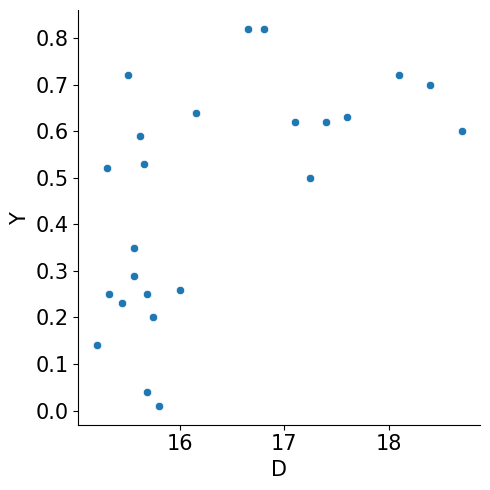

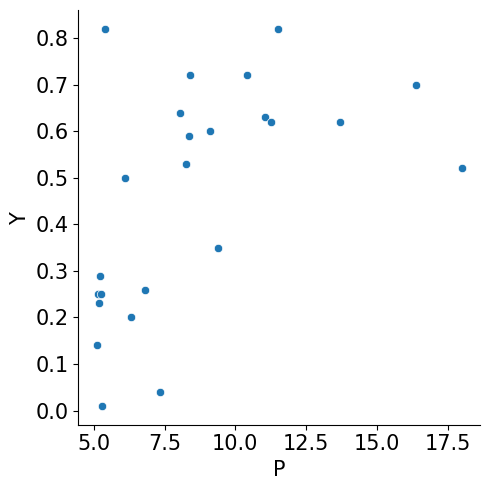

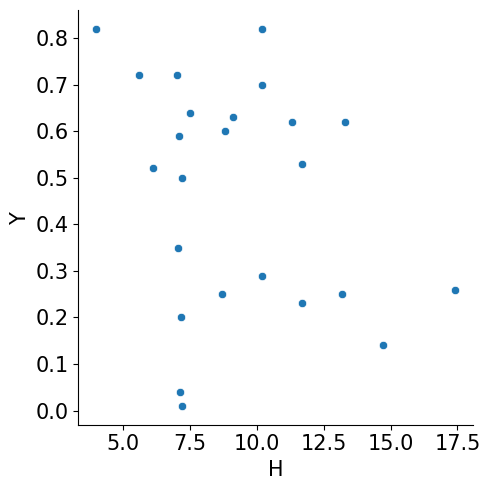

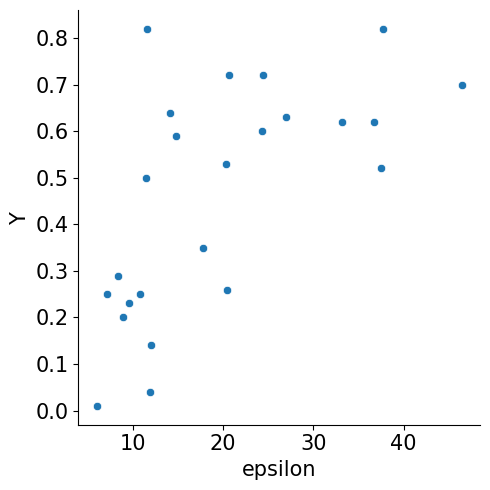

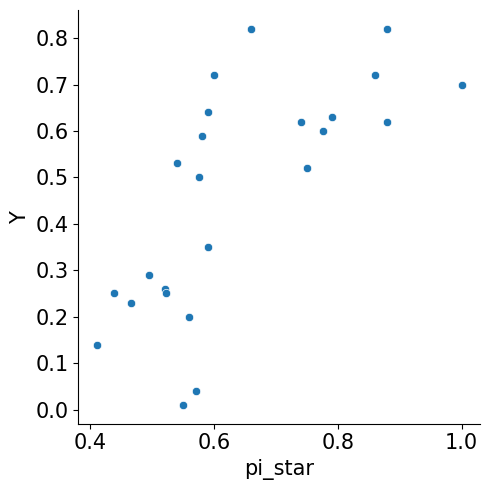

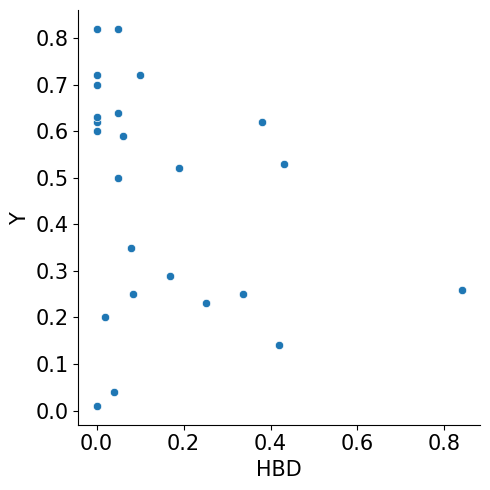

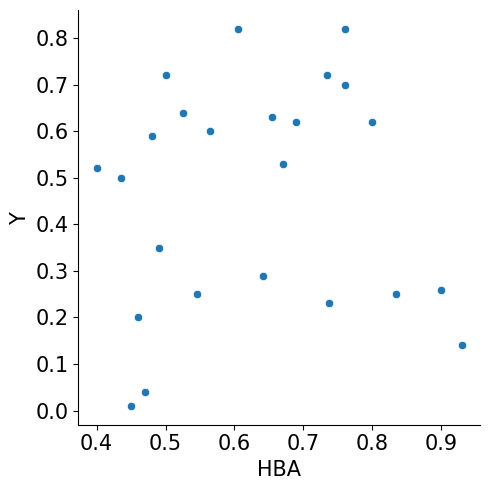

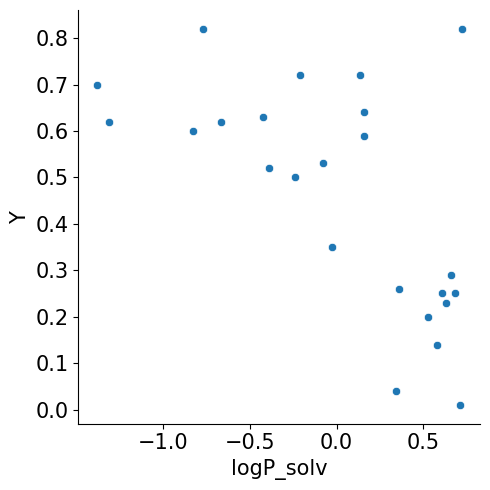

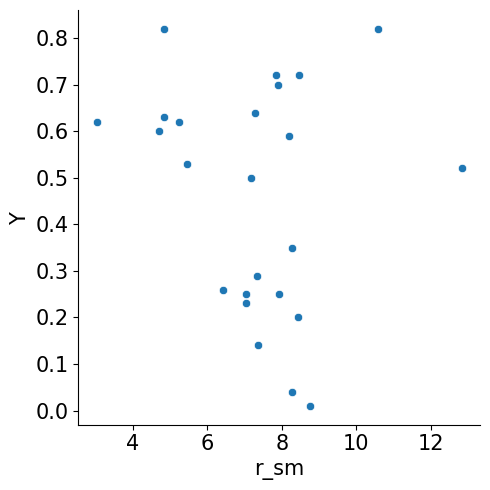

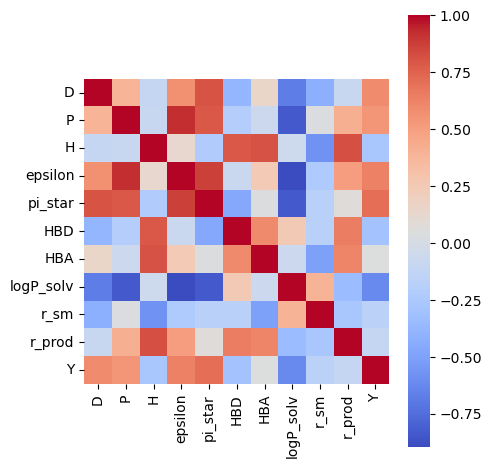

corr_mat_of_descriptors_only.csv saved.
corr_mat_of_descriptors_with_observable.csv saved.


In [296]:
spp.plot_corr(plot_all = True, do_std = False, save_meta_data = True)

In [297]:
spp.dscpt_zscored_df.head()

,D,P,H,epsilon,pi_star,HBD,HBA,logP_solv,r_sm,r_prod
0,0.439018,0.817056,0.284645,1.611915,1.557477,-0.738248,0.876508,-1.227289,-1.230452,0.312723
1,-0.806196,0.504443,-0.741680,0.086518,-0.253292,-0.239151,-0.832682,-0.332294,0.581490,-0.354810
2,1.971589,2.209604,0.284645,2.386224,2.333522,-0.738248,0.876508,-2.202195,0.303726,1.363292
3,1.013732,1.442282,0.637444,1.515461,1.557477,-0.738248,0.416341,-2.090321,-1.034785,0.958991
4,-0.997767,2.664314,-1.030334,1.586909,0.716763,0.210037,-1.490063,-0.619971,2.770944,1.390999


In [298]:
spp.dscpt_with_obs_zscored_df.head()

,Y,D,P,H,epsilon,pi_star,HBD,HBA,logP_solv,r_sm,r_prod
0,1.498429,0.439018,0.817056,0.284645,1.611915,1.557477,-0.738248,0.876508,-1.227289,-1.230452,0.312723
1,1.081716,-0.806196,0.504443,-0.741680,0.086518,-0.253292,-0.239151,-0.832682,-0.332294,0.581490,-0.354810
2,0.998374,1.971589,2.209604,0.284645,2.386224,2.333522,-0.738248,0.876508,-2.202195,0.303726,1.363292
3,0.665004,1.013732,1.442282,0.637444,1.515461,1.557477,-0.738248,0.416341,-2.090321,-1.034785,0.958991
4,0.248291,-0.997767,2.664314,-1.030334,1.586909,0.716763,0.210037,-1.490063,-0.619971,2.770944,1.390999


In [299]:
spp.dscpt_with_obs_zscored_df.head()

,Y,D,P,H,epsilon,pi_star,HBD,HBA,logP_solv,r_sm,r_prod
0,1.498429,0.439018,0.817056,0.284645,1.611915,1.557477,-0.738248,0.876508,-1.227289,-1.230452,0.312723
1,1.081716,-0.806196,0.504443,-0.741680,0.086518,-0.253292,-0.239151,-0.832682,-0.332294,0.581490,-0.354810
2,0.998374,1.971589,2.209604,0.284645,2.386224,2.333522,-0.738248,0.876508,-2.202195,0.303726,1.363292
3,0.665004,1.013732,1.442282,0.637444,1.515461,1.557477,-0.738248,0.416341,-2.090321,-1.034785,0.958991
4,0.248291,-0.997767,2.664314,-1.030334,1.586909,0.716763,0.210037,-1.490063,-0.619971,2.770944,1.390999


PCA starts...
Original descriptors:['D', 'P', 'H', 'epsilon', 'pi_star', 'HBD', 'HBA', 'logP_solv', 'r_sm', 'r_prod']
PCA completed. 
 Please refer to pca_log for details.
pca_scree_plot_n_10:



<Figure size 640x480 with 0 Axes>

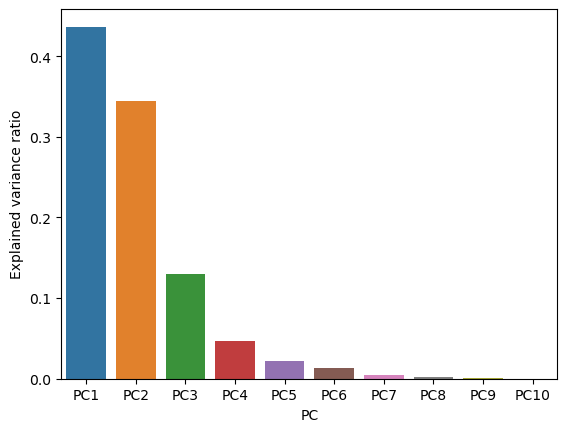

pca_scree_plot_n_10.csv saved.
pca_loading_matrix_n_10:



<Figure size 640x480 with 0 Axes>

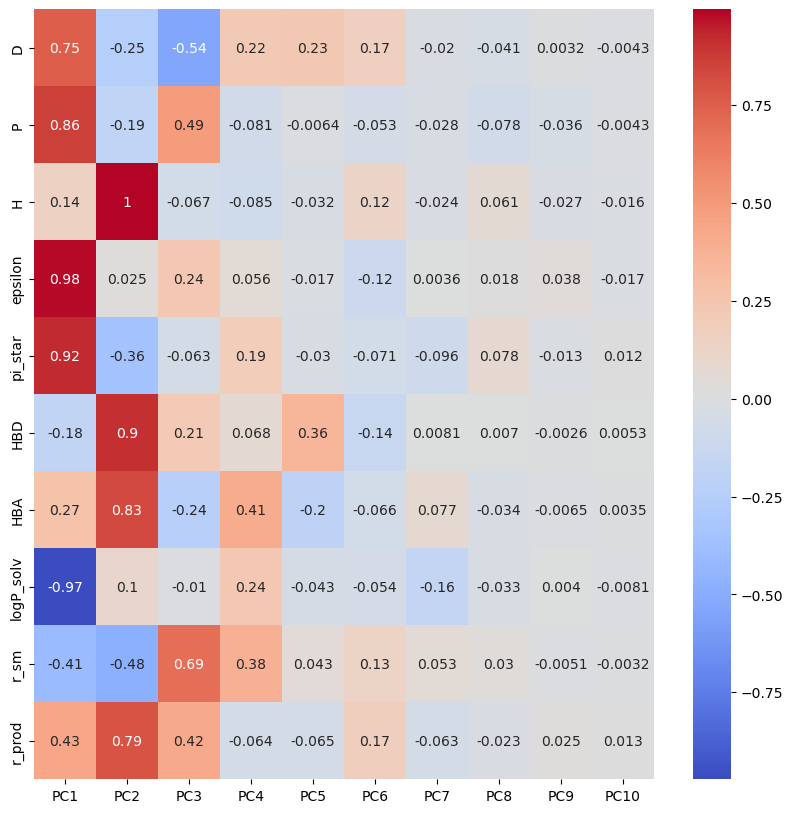

pca_loading_matrix_n_10.csv saved.


In [300]:
spp.do_pca() #full pca to see contribution of all PCs

In [301]:
spp.inv_pca_coord()

Inverse PCA starts...
Inverse PCA done.
['D', 'P', 'H', 'epsilon', 'pi_star', 'HBD', 'HBA', 'logP_solv', 'r_sm', 'r_prod']
 for PC coordinate: [ 5 -1] in the original dimension space is:
 [ 1.88595245  2.12290134 -0.18856652  2.29149622  2.35281577 -0.88834338
  0.18448096 -2.33100409 -0.7056177   0.5996293 ].

inverse_pca_df_5_-1.csv saved.


In [302]:
spp.inv_pca_full_log

{'n_comp': 2,
 'coord_to_inv': array([ 5, -1]),
 'descriptors': ['D',
  'P',
  'H',
  'epsilon',
  'pi_star',
  'HBD',
  'HBA',
  'logP_solv',
  'r_sm',
  'r_prod'],
 'orig_space_value': array([ 1.88595245,  2.12290134, -0.18856652,  2.29149622,  2.35281577,
        -0.88834338,  0.18448096, -2.33100409, -0.7056177 ,  0.5996293 ])}

In [303]:
# default_n_comp = spp.num_of_dscpt

spp.pca_log

{'n_comp': 10,
 'pca_ip_data':            D         P         H   epsilon   pi_star       HBD       HBA  \
 0   0.439018  0.817056  0.284645  1.611915  1.557477 -0.738248  0.876508   
 1  -0.806196  0.504443 -0.741680  0.086518 -0.253292 -0.239151 -0.832682   
 2   1.971589  2.209604  0.284645  2.386224  2.333522 -0.738248  0.876508   
 3   1.013732  1.442282  0.637444  1.515461  1.557477 -0.738248  0.416341   
 4  -0.997767  2.664314 -1.030334  1.586909  0.716763  0.210037 -1.490063   
 5  -0.327268 -0.518653  2.593876  0.064191 -0.770655  3.454169  1.796841   
 6  -1.093553 -1.001782  1.727915 -0.690470 -1.482029  1.357961  1.994055   
 7  -0.518839 -0.944943 -0.677535 -1.224538 -0.576644 -0.738248 -1.161373   
 8  -0.748725  0.214566 -0.728851 -0.175693 -0.317963 -0.338970 -0.898420   
 9  -0.691253 -0.075311 -0.716022 -0.437904 -0.382633 -0.438790 -0.964159   
 10 -0.633782 -0.365189 -0.703193 -0.700115 -0.447303 -0.538609 -1.029897   
 11 -0.576311 -0.655066 -0.690364 -0.962326 -0

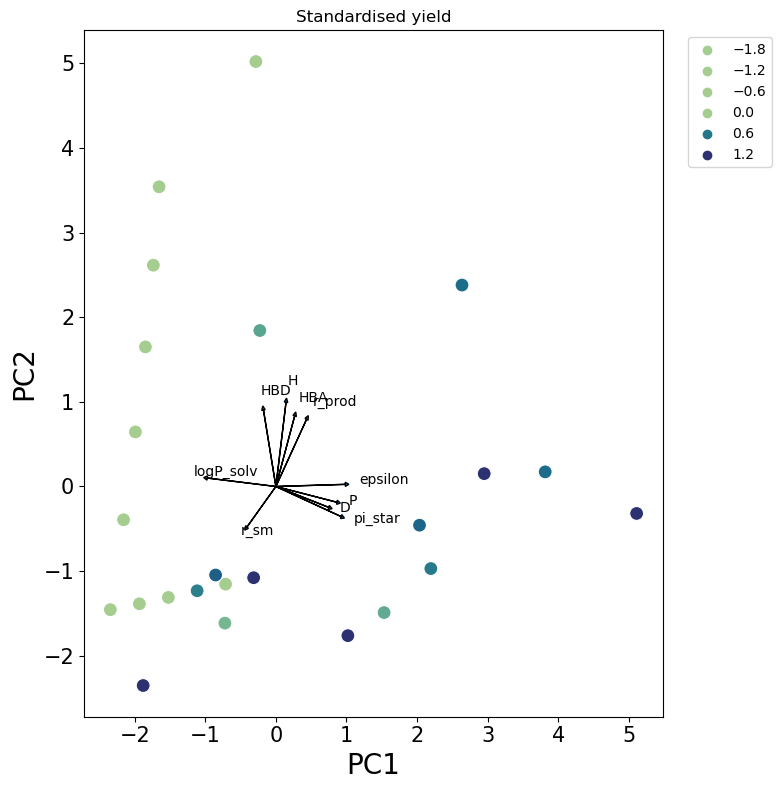

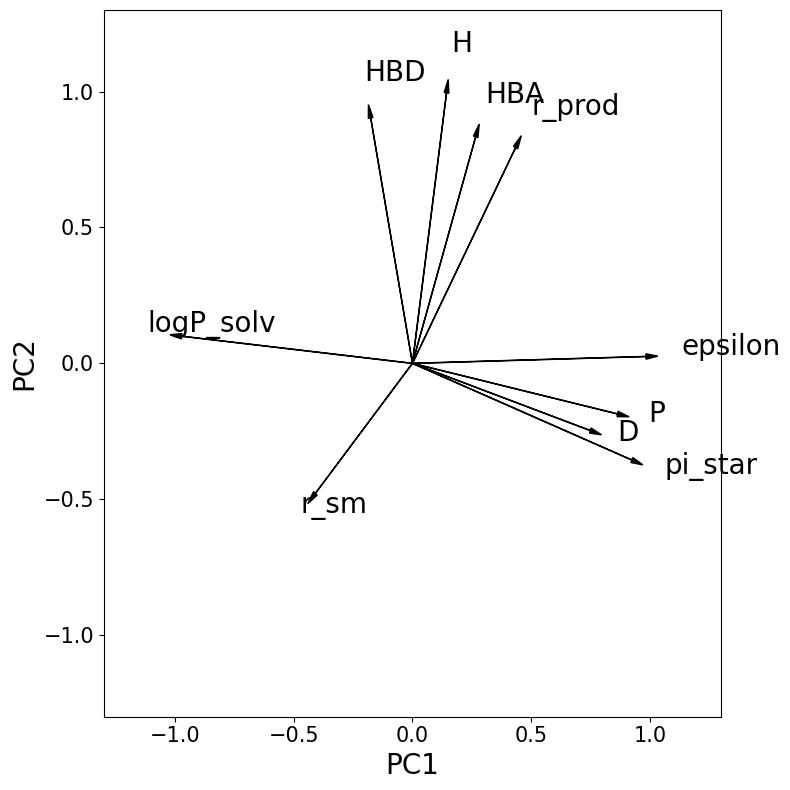

In [304]:
spp.get_pc_map(n_comp = 2)

In [305]:
spp.sel_feature(n_comp = 2, pc_to_rank = 'PC1', abs_value = True)

The absolute projection of all descriptors on PC1 axis is: 

epsilon      0.983794
logP_solv    0.972463
pi_star      0.924214
P            0.864230
D            0.749329
r_prod       0.434760
r_sm         0.408919
HBA          0.266419
HBD          0.175824
H            0.143636
Name: PC1, dtype: float64
The best descriptor is: epsilon. 
 Projection: 0.9837942569191095. 

The full feature selection log can be found by calling: sel_feature_log



In [306]:
spp.sel_feature_log

{'pc_to_rank': 'PC1',
 'do_abs': True,
 'loading_col_to_rank': D            0.749329
 P            0.864230
 H            0.143636
 epsilon      0.983794
 pi_star      0.924214
 HBD         -0.175824
 HBA          0.266419
 logP_solv   -0.972463
 r_sm        -0.408919
 r_prod       0.434760
 Name: PC1, dtype: float64,
 'ranked_loading_col': epsilon      0.983794
 logP_solv    0.972463
 pi_star      0.924214
 P            0.864230
 D            0.749329
 r_prod       0.434760
 r_sm         0.408919
 HBA          0.266419
 HBD          0.175824
 H            0.143636
 Name: PC1, dtype: float64,
 'best_descriptor': 'epsilon',
 'best_descriptor_projection': 0.9837942569191095}

In [307]:
spp.hop_back_to_high_dim()

             orig_space_value
descriptors                  
D                    1.885952
P                    2.122901
H                   -0.188567
epsilon              2.291496
pi_star              2.352816
HBD                 -0.888343
HBA                  0.184481
logP_solv           -2.331004
r_sm                -0.705618
r_prod               0.599629
The standardised value of epsilon in the original feature space is: 2.291496217376005


In [137]:
spp.sel_feature_log["ranked_loading_col"].index[0]

'epsilon'

In [120]:
spp.sel_feature_log["ranked_loading_col"][0]

0.9837942569191095

In [ ]:
all_solv_cand_df = pd.read_csv(all_cand_param_name)
# all_solv_cand_df.to_dict(orient = "records")

In [551]:
all_solv_cand_df.head()

,solvent,D,P,H,epsilon,pi_star,HBD,HBA,logP_solv
0,DMAC,16.8,11.5,10.2,37.78,0.88,0.00,0.76,-0.77
1,Acetone,15.5,10.4,7.0,20.70,0.60,0.10,0.50,-0.21
2,DMSO,18.4,16.4,10.2,46.45,1.00,0.00,0.76,-1.38
3,DMF,17.4,13.7,11.3,36.70,0.88,0.00,0.69,-1.31
4,ACN,15.3,18.0,6.1,37.50,0.75,0.19,0.40,-0.39


In [552]:
all_solv_cand_df['new_col_test'] = (all_solv_cand_df['D']-1)**2+(all_solv_cand_df['P']+1)**2

In [553]:
all_solv_cand_df.head()

,solvent,D,P,H,epsilon,pi_star,HBD,HBA,logP_solv,new_col_test
0,DMAC,16.8,11.5,10.2,37.78,0.88,0.00,0.76,-0.77,405.89
1,Acetone,15.5,10.4,7.0,20.70,0.60,0.10,0.50,-0.21,340.21
2,DMSO,18.4,16.4,10.2,46.45,1.00,0.00,0.76,-1.38,605.52
3,DMF,17.4,13.7,11.3,36.70,0.88,0.00,0.69,-1.31,485.05
4,ACN,15.3,18.0,6.1,37.50,0.75,0.19,0.40,-0.39,565.49


In [554]:
full_exp_df = pd.read_csv(ip_exp_csv_name)
full_exp_df.head()

,rxn_id,solv_1,percent_1,solv_2,percent_2,Y
0,Xf2346,DMAC,1.0,NaN,NaN,0.82
1,Xf2353,Acetone,1.0,NaN,NaN,0.72
2,Xf2345,DMSO,1.0,NaN,NaN,0.70
3,Xf2344,DMF,1.0,NaN,NaN,0.62
4,Xf2352,ACN,1.0,NaN,NaN,0.52


In [555]:
full_exp_df.to_dict(orient = "records")

[{'rxn_id': 'Xf2346',
  'solv_1': 'DMAC',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.82},
 {'rxn_id': 'Xf2353',
  'solv_1': 'Acetone',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.72},
 {'rxn_id': 'Xf2345',
  'solv_1': 'DMSO',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.7},
 {'rxn_id': 'Xf2344',
  'solv_1': 'DMF',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.62},
 {'rxn_id': 'Xf2352',
  'solv_1': 'ACN',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.52},
 {'rxn_id': 'Xf2350',
  'solv_1': 'NPA',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.26},
 {'rxn_id': 'Xf2351',
  'solv_1': 'tBuOH',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.14},
 {'rxn_id': 'Xf2356',
  'solv_1': 'EA',
  'percent_1': 1.0,
  'solv_2': nan,
  'percent_2': nan,
  'Y': 0.01},
 {'rxn_id': 'xf2379',
  'solv_1': 'EA',
  'percent_1': 0.2,
  'solv_2': 'acetone',
  'percent_2': 

In [556]:
all_col = full_exp_df.columns

In [557]:
for i, col in enumerate(all_col):
    if "solv" in col.lower():
        this_solv = col
        this_precent = all_col[i+1]
        print(this_solv)
        print(this_precent)

solv_1
percent_1
solv_2
percent_2


In [558]:
#parse column name and extract solv, precent part
def parse_co_solv(full_exp_df):
    all_col = full_exp_df.columns
    
    all_co_solv = {
        "solv_col":[],
        "percent_col":[]
    }
    
    for i, col in enumerate(all_col):
        if "solv" in col.lower():
            this_solv_col = col
            this_percent_col = all_col[i+1]
            all_co_solv["solv_col"].append(this_solv_col)
            all_co_solv["percent_col"].append(this_percent_col)
    
    return all_co_solv
            

In [25]:
all_co_solv = parse_co_solv(full_exp_df)
print(all_co_solv)

{'solv_col': ['solv_1', 'solv_2'], 'percent_col': ['percent_1', 'percent_2']}
